# Демонстрация процесса обучения модели на примере классификации

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импорт необходимых библиотек для анализа
import pandas as pd
import numpy as np
from scipy.stats import skew, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Импорт необходимых библиотек для схемы обучения и проверки
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score

# Импорт необходимых алгоритмов для обучения
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

In [3]:
# Определение пути разработанной библиотеки
import sys
sys.path.append('../')

In [4]:
# Наша разработанная библиотека
from autobinary import NansAnalysis, base_pipe, StratifiedGroupKFold, PrimarySelection
from autobinary import AutoTrees, AutoSelection
from autobinary import FinalModel, PlotShap, PlotPDP

In [5]:
import sklearn as sk
import catboost as ctb
import matplotlib as mplot
import autobinary as ab
import numpy as np
import scipy as sc

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('sklearn: ', sk.__version__)
print('lightboost: ', ctb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.5.3
numpy:  1.22.2
scipy:  1.7.3
sklearn:  1.1.3
lightboost:  1.0.4
matplotlib:  3.7.0
autobinary:  1.0.9


## Начало анализа

In [6]:
sample = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

In [7]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

features = num_columns + cat_columns

target = 'Survived'

In [8]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns
)

Определены количественные и категориальные переменные!


In [9]:
# обработка бесконечных и пропущенных значений

nans = NansAnalysis(df=sample)

sample = nans.to_types(num_columns=num_columns)
sample.head()

Все бесконечные значения заменены на пропуски, количественные переменные приведены к типу float!


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [10]:
# Проводим анализ на пропущенные значения. Столбцы имеющие пропусков больше percent.

feat_after_nans = nans.fit(percent = 0.9)

# Обновляем факторы

num_columns = list(filter(lambda x: x in feat_after_nans, num_columns))
cat_columns = list(filter(lambda x: x in feat_after_nans, cat_columns))

Количество столбцов до: 12
Удалены столбцы, имеющие долю пропусков > 90.0 %, количество оставшихся : 12 


In [11]:
# Функция nans_df - датафрейм с пропущенными значениями

nans.nans_df

feature  cnt_null  share_nans
10        Cabin       687        0.77
5           Age       177        0.20
11     Embarked         2        0.00
0   PassengerId         0        0.00
1      Survived         0        0.00
2        Pclass         0        0.00
3          Name         0        0.00
4           Sex         0        0.00
6         SibSp         0        0.00
7         Parch         0        0.00
8        Ticket         0        0.00
9          Fare         0        0.00

In [12]:
# Разделим генеральную совокупность на обучающее и тестовое множества.

X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [13]:
# Инициализация класса первичного отбора факторов

feature_selection = PrimarySelection(df_train=X_train,
                                     base_pipe=base_pipe,
                                     num_columns=num_columns,
                                     cat_columns=cat_columns,
                                     target=target,
                                     model_type='lightboost',
                                     task_type='classification')

Класс первичного отбора факторов инициализирован!


In [14]:
# Корреляционный анализ 

feat_after_corr = feature_selection.corr_analysis(method='spearman',
                                                  threshold=0.4, 
                                                  drop_with_most_correlations=True)

Определены количественные и категориальные переменные!
Количество факторов до: 7
Количество факторов после корреляционного анализа: 6


In [15]:
# функция corr_df - датафрейм с коррелирующими факторами

feature_selection.corr_df

Корреляция более 40.0%
Pclass               ['Fare']

In [16]:
# функция metric_res - датафрейм с метриками однофакторного анализа

feature_selection.metric_res

metric
Sex       54.1383
Fare      38.6561
Pclass    35.5899
Embarked  17.5231
Parch     17.3706
SibSp     17.2877
Age        2.5410

In [17]:
# Функция feat_after_corr - список факторов после корреляционного анализа

feature_selection.feat_after_corr

['Embarked', 'Age', 'Sex', 'Fare', 'SibSp', 'Parch']

In [18]:
# Анализ относительно глубины

depth_features, rank_features = feature_selection.depth_analysis(features=feat_after_corr,
                                                                 max_depth=3)

Определены количественные и категориальные переменные!


  0%|          | 0/3 [00:00<?, ?it/s]

Количество признаков до отбора: 6
Количество признаков после mean importance относительно глубины: 6
Количество признаков после mean rank относительно глубины: 6


In [19]:
feature_selection.fi.head(5)

importance_depth_1  importance_depth_2  importance_depth_3  \
Sex           9248.759086         9802.779716         9991.386434   
Fare          2676.378949         3322.974358         4341.057824   
Age              0.000000          999.698651         1670.168675   
SibSp          571.306269          770.071167          916.275160   
Parch            0.000000          151.053780          525.644644   

       mean_importance  mean_rank  
Sex        9680.975079   0.323810  
Fare       3446.803711   0.258730  
Age         889.955776   0.126984  
SibSp       752.550865   0.161905  
Parch       225.566141   0.063492

In [20]:
# задаем стратегию проверки
strat = StratifiedKFold(n_splits=3,
                        shuffle=True,
                        random_state=42)

In [21]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       group=None,
                                       n_iter=30,
                                       permute_type='kib',
                                       n_jobs=-1,
                                       metric=roc_auc_score,
                                       higher_is_better=True)

Размер обучающего подмножества для Permutation importance: (415, 12) ; Среднее значение таргета: 0.38313253012048193

Размер тестового подмножества для Permutation importance: (208, 12) ; Среднее значение таргета: 0.38461538461538464
Определены количественные и категориальные переменные!
Расчет Permutation Importance на Train


100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 396.53it/s]
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarnin

Расчет Permutation Importance на Test


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2630.84it/s]
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/vasilij/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarnin

Perm_Importance_Tr  Perm_Importance_Te
Feature                                               
Sex                       0.244418            0.245475
Fare                      0.143502            0.083280
Age                       0.022683            0.014850
random_feature            0.071572            0.010107
Parch                     0.004814            0.004814
SibSp                     0.004563            0.004606
Embarked                  0.008830            0.001657

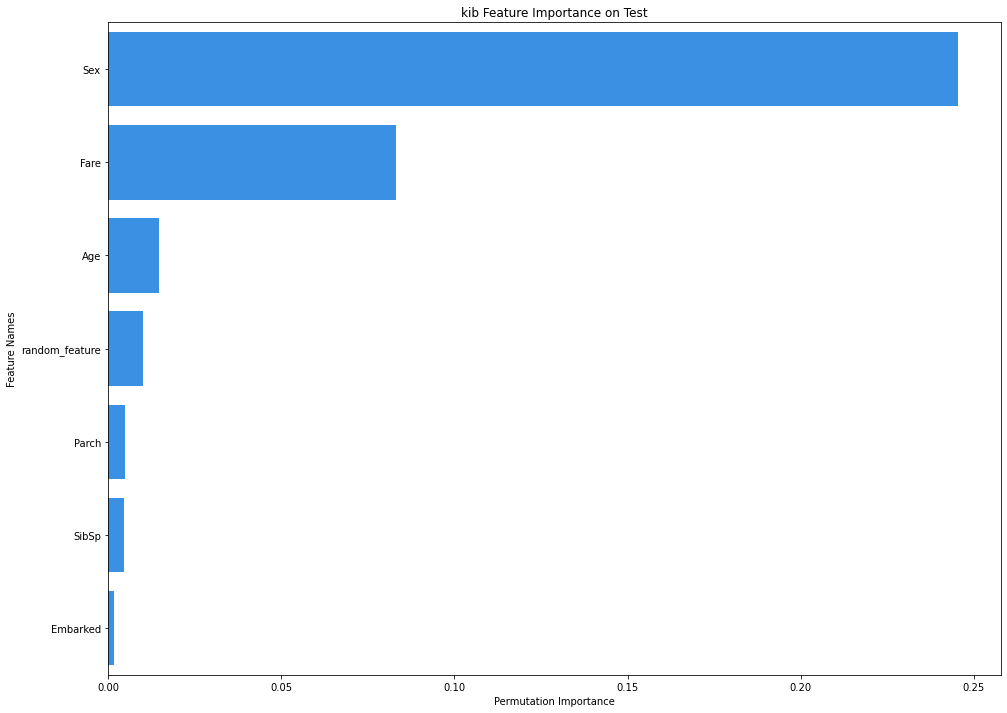

In [22]:
# Отрисовка топ факторов по Permutation Importance

feature_selection.permutation_plot(figsize=(16,12), top=10)

In [23]:
# Получаем факторы после анализа пермутейшн

features_after_permutation = feature_selection.select_features()

# Обновляем признаки
num_columns = list(filter(lambda x: x in features_after_permutation, num_columns))
cat_columns = list(filter(lambda x: x in features_after_permutation, cat_columns))

7 признаков было до Permutation Importance 

3 признаков после Permutation Importance от kib


## Расчет важностей по кросс-валидации

In [24]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [25]:
params = {
    'learning_rate':0.01,
    'n_estimators':1000,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary',
    'n_jobs':-1,
    'random_state':42,
#    'eval_metric':'auc'
}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':25}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [26]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [27]:
model.model_fit_cv(strat=strat)

1it [00:00,  9.76it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.584313	training's auc: 0.881977	valid_1's binary_logloss: 0.604333	valid_1's auc: 0.803707
[50]	training's binary_logloss: 0.534124	training's auc: 0.890138	valid_1's binary_logloss: 0.569415	valid_1's auc: 0.808983
[75]	training's binary_logloss: 0.496835	training's auc: 0.892917	valid_1's binary_logloss: 0.546755	valid_1's auc: 0.806548
[100]	training's binary_logloss: 0.469893	training's auc: 0.895382	valid_1's binary_logloss: 0.530717	valid_1's auc: 0.806548
[125]	training's binary_logloss: 0.449646	training's auc: 0.898289	valid_1's binary_logloss: 0.521811	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.433322	training's auc: 0.900114	valid_1's binary_logloss: 0.514414	valid_1's auc: 0.802219
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.811

********************** 1 фолд обучен! ******************************


==================== 

2it [00:00,  7.31it/s]

[175]	training's binary_logloss: 0.424676	training's auc: 0.900515	valid_1's binary_logloss: 0.500354	valid_1's auc: 0.834145
[200]	training's binary_logloss: 0.413298	training's auc: 0.902084	valid_1's binary_logloss: 0.496721	valid_1's auc: 0.832251
[225]	training's binary_logloss: 0.402665	training's auc: 0.905103	valid_1's binary_logloss: 0.49753	valid_1's auc: 0.829545
[250]	training's binary_logloss: 0.393341	training's auc: 0.908889	valid_1's binary_logloss: 0.501086	valid_1's auc: 0.82711
BEST ITERATION:  163
roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.583592	training's auc: 0.885959	valid_1's binary_logloss: 0.601347	valid_1's auc: 0.791126
[50]	training's binary_logloss: 0.534302	training's auc: 0.895919	valid_1's binary_logloss: 0.571437	valid_1's auc: 0.784361
[75]	training's binar

4it [00:00,  8.28it/s]

[125]	training's binary_logloss: 0.474083	training's auc: 0.88383	valid_1's binary_logloss: 0.447603	valid_1's auc: 0.899834
[150]	training's binary_logloss: 0.459757	training's auc: 0.884161	valid_1's binary_logloss: 0.429714	valid_1's auc: 0.900387
[175]	training's binary_logloss: 0.447762	training's auc: 0.88691	valid_1's binary_logloss: 0.416969	valid_1's auc: 0.898314
[200]	training's binary_logloss: 0.437745	training's auc: 0.887427	valid_1's binary_logloss: 0.405955	valid_1's auc: 0.896933
BEST ITERATION:  117
roc_auc на обучающей выборке: 0.885
roc_auc на проверочной выборке: 0.901

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.589416	training's auc: 0.870818	valid_1's binary_logloss: 0.595452	valid_1's auc: 0.860471
[50]	training's binary_logloss: 0.543611	training's auc: 0.878901	valid_1's binary_logloss: 0.554637	valid_1's auc: 0.871436
[75]	training's binar

5it [00:00,  7.24it/s]

[325]	training's binary_logloss: 0.391291	training's auc: 0.902274	valid_1's binary_logloss: 0.423147	valid_1's auc: 0.891447
[350]	training's binary_logloss: 0.386418	training's auc: 0.904875	valid_1's binary_logloss: 0.422187	valid_1's auc: 0.889803
[375]	training's binary_logloss: 0.38247	training's auc: 0.906482	valid_1's binary_logloss: 0.421838	valid_1's auc: 0.888432
BEST ITERATION:  279
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.893

********************** 5 фолд обучен! ******************************




In [28]:
model.get_mean_cv_scores()

0.8469565475584512

In [29]:
model._best_iters

[53, 163, 1, 117, 279]

In [30]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.889882   0.899134   0.876401   0.884645   0.897056
1   roc_valid   0.810606   0.837392   0.792749   0.901492   0.892544
2  gini_train  77.976363  79.826731  75.280113  76.928950  79.411165
3  gini_valid  62.121212  67.478355  58.549784  80.298425  78.508772

In [31]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  importance 3  importance 4  \
0   Sex   4508.722000   6526.341434    158.863998   5379.639397   7377.475760   
1  Fare   2046.358905   4441.402659     53.607419   3591.145588   4594.700110   
2   Age    305.271392    763.103586      0.000000    384.879259   1227.281355   

   mean_importance  
0      4790.208518  
1      2945.442936  
2       536.107118

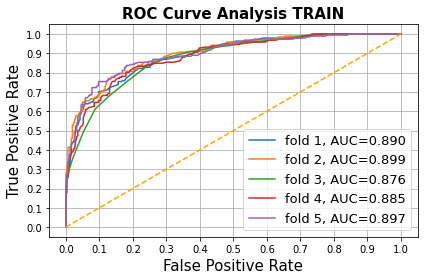

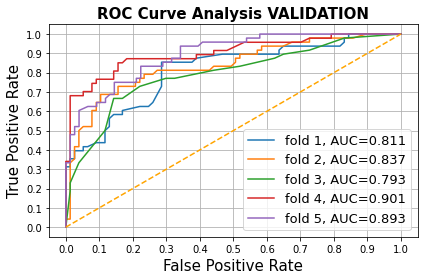

In [32]:
model.get_rocauc_plots()

In [33]:
model.get_curve_plots()

## Жадные отборы Forward и Backward selection

In [34]:
selection = AutoSelection(base_pipe=base_pipe,
                          num_columns=num_columns,
                          cat_columns=cat_columns,
                          main_fit_params=fit_params,
                          main_estimator=lgb_model,
                          
                          X_train=X_train,
                          y_train=y_train,
                          main_metric='roc_auc',
                          model_type='lightboost')

Определены количественные и категориальные переменные!


In [35]:
fselection_res = selection.forward_selection(strat=strat)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.584313	training's auc: 0.881977	valid_1's binary_logloss: 0.604333	valid_1's auc: 0.803707
[50]	training's binary_logloss: 0.534124	training's auc: 0.890138	valid_1's binary_logloss: 0.569415	valid_1's auc: 0.808983
[75]	training's binary_logloss: 0.496835	training's auc: 0.892917	valid_1's binary_logloss: 0.546755	valid_1's auc: 0.806548


1it [00:00,  2.99it/s]

[100]	training's binary_logloss: 0.469893	training's auc: 0.895382	valid_1's binary_logloss: 0.530717	valid_1's auc: 0.806548
[125]	training's binary_logloss: 0.449646	training's auc: 0.898289	valid_1's binary_logloss: 0.521811	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.433322	training's auc: 0.900114	valid_1's binary_logloss: 0.514414	valid_1's auc: 0.802219
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.811

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.585877	training's auc: 0.87924	valid_1's binary_logloss: 0.599863	valid_1's auc: 0.827246
[50]	training's binary_logloss: 0.537239	training's auc: 0.885831	valid_1's binary_logloss: 0.566424	valid_1's auc: 0.823458
[75]	training's binary_logloss: 0.502206	training's auc: 0.888006	valid_1's binary_logloss: 0.542905	valid_1's auc: 0.818994
[100]	training's binar

2it [00:00,  1.97it/s]

BEST ITERATION:  163
roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.583592	training's auc: 0.885959	valid_1's binary_logloss: 0.601347	valid_1's auc: 0.791126
[50]	training's binary_logloss: 0.534302	training's auc: 0.895919	valid_1's binary_logloss: 0.571437	valid_1's auc: 0.784361
[75]	training's binary_logloss: 0.497266	training's auc: 0.904054	valid_1's binary_logloss: 0.55137	valid_1's auc: 0.78355
[100]	training's binary_logloss: 0.468851	training's auc: 0.906186	valid_1's binary_logloss: 0.536871	valid_1's auc: 0.785173
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.876
roc_auc на проверочной выборке: 0.793

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.593405	training

5it [00:01,  3.70it/s]


roc_auc на обучающей выборке: 0.885
roc_auc на проверочной выборке: 0.901

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.589416	training's auc: 0.870818	valid_1's binary_logloss: 0.595452	valid_1's auc: 0.860471
[50]	training's binary_logloss: 0.543611	training's auc: 0.878901	valid_1's binary_logloss: 0.554637	valid_1's auc: 0.871436
[75]	training's binary_logloss: 0.509566	training's auc: 0.883049	valid_1's binary_logloss: 0.523575	valid_1's auc: 0.872122
[100]	training's binary_logloss: 0.483301	training's auc: 0.883899	valid_1's binary_logloss: 0.498721	valid_1's auc: 0.878152
[125]	training's binary_logloss: 0.463656	training's auc: 0.887673	valid_1's binary_logloss: 0.478912	valid_1's auc: 0.888021
[150]	training's binary_logloss: 0.447773	training's auc: 0.890018	valid_1's binary_logloss: 0.46502	valid_1's auc: 0.886924
[175]	training's binary_logloss: 0.435165	

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


2it [00:00, 17.94it/s]

[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.607059	training's auc: 0.768653	valid_1's binary_logloss: 0.604705	valid_1's auc: 0.778815
[50]	training's binary_logloss: 0.571424	training's auc: 0.768653	valid_1's binary_logloss: 0.567001	valid_1's auc: 0.778815
[75]	training's binary_lo

4it [00:00, 18.24it/s]

[100]	training's binary_logloss: 0.547483	training's auc: 0.756786	valid_1's binary_logloss: 0.497208	valid_1's auc: 0.826886
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 18.16it/s]


[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	valid_1's binary_logloss: 0.608652	valid_1's auc: 0.764803
[50]	training's binary_logloss: 0.568122	training's auc: 0.772132	valid_1's binary_logloss: 0.573518	valid_1's auc: 0.764803
[75]	training's binary_logloss: 0.545269	training's auc: 0.772132	valid_1's binary_logloss: 0.552096	valid_1's auc: 0.764803
[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 0.7707998235433846
Добавление признака Fare
Определены количественные и категориальные переменные!


1it [00:00,  9.22it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.609082	training's auc: 0.863363	valid_1's binary_logloss: 0.619579	valid_1's auc: 0.795455
[50]	training's binary_logloss: 0.567416	training's auc: 0.863951	valid_1's binary_logloss: 0.58747	valid_1's auc: 0.796537
[75]	training's binary_logloss: 0.536705	training's auc: 0.863695	valid_1's binary_logloss: 0.565268	valid_1's auc: 0.798701
[100]	training's binary_logloss: 0.513059	training's auc: 0.865836	valid_1's binary_logloss: 0.548403	valid_1's auc: 0.803571
[125]	training's binary_logloss: 0.4949	training's auc: 0.86859	valid_1's binary_logloss: 0.535788	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.48042	training's auc: 0.868812	valid_1's binary_logloss: 0.525222	valid_1's auc: 0.800595
[175]	training's binary_logloss: 0.469367	training's auc: 0.869784	valid_1's binary_logloss: 0.518391	valid_1's auc: 0.80276
[200]	training's binary_logloss: 0.460606	training's auc: 0.871574	

2it [00:00,  7.52it/s]

[225]	training's binary_logloss: 0.453133	training's auc: 0.876221	valid_1's binary_logloss: 0.504473	valid_1's auc: 0.826434
[250]	training's binary_logloss: 0.446153	training's auc: 0.877006	valid_1's binary_logloss: 0.500407	valid_1's auc: 0.828598
[275]	training's binary_logloss: 0.440105	training's auc: 0.878063	valid_1's binary_logloss: 0.498379	valid_1's auc: 0.827516
[300]	training's binary_logloss: 0.434643	training's auc: 0.87849	valid_1's binary_logloss: 0.496244	valid_1's auc: 0.828328
[325]	training's binary_logloss: 0.429939	training's auc: 0.879573	valid_1's binary_logloss: 0.495007	valid_1's auc: 0.823728
BEST ITERATION:  243
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.608012	training's auc: 0.877339	valid_1's binary_logloss: 0.629129	valid_1's auc: 0.753382
[50]	training's bin

5it [00:00,  9.89it/s]


[200]	training's binary_logloss: 0.482245	training's auc: 0.859859	valid_1's binary_logloss: 0.437375	valid_1's auc: 0.900525
BEST ITERATION:  105
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.610899	training's auc: 0.853369	valid_1's binary_logloss: 0.615724	valid_1's auc: 0.836897
[50]	training's binary_logloss: 0.570808	training's auc: 0.854899	valid_1's binary_logloss: 0.578196	valid_1's auc: 0.8358
[75]	training's binary_logloss: 0.542024	training's auc: 0.857245	valid_1's binary_logloss: 0.552522	valid_1's auc: 0.83443
[100]	training's binary_logloss: 0.519891	training's auc: 0.85784	valid_1's binary_logloss: 0.532884	valid_1's auc: 0.82881
BEST ITERATION:  11
roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.844

********************** 5 фолд обучен! ******************

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.594775	training's auc: 0.864787	valid_1's binary_logloss: 0.621003	valid_1's auc: 0.719832
[50]	training's binary_logloss: 0.546013	training's auc: 0.885482	valid_1's binary_logloss: 0.591123	valid_1's auc: 0.750271
[75]	training's binary_logloss: 0.508462	training's auc: 0.890982	valid_1's binary_logloss: 0.56958	valid_1's auc: 0.762175
[100]	training's binary_logloss: 0.480726	training's auc: 0.892576	valid_1's binary_logloss: 0.555097	valid_1's auc: 0.763799
[125]	training's binary_logloss: 0.457487	training's auc: 0.9002	valid_1's binary_logloss: 0.541528	valid_1's auc: 0.775027
[150]	training's binary_logloss: 0.43908	training's auc: 0.904531	valid_1's binary_logloss: 0.531794	valid_1's auc: 0.782332
[175]	training's binary_logloss: 0.426223	training's auc: 0.90581	valid_1's binary_logloss: 0.525819	valid_1's auc: 0.787879
[200]	training's binary_logloss: 0.416481	training's auc: 0.906339

1it [00:00,  4.08it/s]

[400]	training's binary_logloss: 0.364079	training's auc: 0.922447	valid_1's binary_logloss: 0.515877	valid_1's auc: 0.801136
[425]	training's binary_logloss: 0.359684	training's auc: 0.924655	valid_1's binary_logloss: 0.514545	valid_1's auc: 0.800325
BEST ITERATION:  333
roc_auc на обучающей выборке: 0.919
roc_auc на проверочной выборке: 0.803

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.597995	training's auc: 0.857573	valid_1's binary_logloss: 0.608375	valid_1's auc: 0.790314
[50]	training's binary_logloss: 0.552325	training's auc: 0.880383	valid_1's binary_logloss: 0.576427	valid_1's auc: 0.802624
[75]	training's binary_logloss: 0.518507	training's auc: 0.887358	valid_1's binary_logloss: 0.553297	valid_1's auc: 0.804924
[100]	training's binary_logloss: 0.492293	training's auc: 0.890308	valid_1's binary_logloss: 0.534839	valid_1's auc: 0.805195
[125]	training's bin

2it [00:00,  4.87it/s]

roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.812

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.596901	training's auc: 0.857249	valid_1's binary_logloss: 0.606491	valid_1's auc: 0.8079
[50]	training's binary_logloss: 0.55173	training's auc: 0.881756	valid_1's binary_logloss: 0.575879	valid_1's auc: 0.796943
[75]	training's binary_logloss: 0.516959	training's auc: 0.889251	valid_1's binary_logloss: 0.551906	valid_1's auc: 0.803571
[100]	training's binary_logloss: 0.490285	training's auc: 0.894648	valid_1's binary_logloss: 0.534443	valid_1's auc: 0.803571
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.60056	training's auc: 0.85532	valid_1

4it [00:00,  5.73it/s]

[425]	training's binary_logloss: 0.398877	training's auc: 0.902229	valid_1's binary_logloss: 0.402301	valid_1's auc: 0.885466
[450]	training's binary_logloss: 0.395948	training's auc: 0.903366	valid_1's binary_logloss: 0.402484	valid_1's auc: 0.886295
[475]	training's binary_logloss: 0.392378	training's auc: 0.90491	valid_1's binary_logloss: 0.40283	valid_1's auc: 0.884775
BEST ITERATION:  387
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.889

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.593719	training's auc: 0.867784	valid_1's binary_logloss: 0.608546	valid_1's auc: 0.786184
[50]	training's binary_logloss: 0.548428	training's auc: 0.883814	valid_1's binary_logloss: 0.573601	valid_1's auc: 0.794134
[75]	training's binary_logloss: 0.515297	training's auc: 0.885905	valid_1's binary_logloss: 0.548648	valid_1's auc: 0.798657
[100]	training's binar

5it [00:01,  4.39it/s]

[625]	training's binary_logloss: 0.357755	training's auc: 0.918857	valid_1's binary_logloss: 0.470564	valid_1's auc: 0.832237
BEST ITERATION:  536
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.836

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 0.8305476275311101

Количество отобранных признаков: 3
Метрика до отбора: 0.847 => после отбора: 0.8305
Конец жадного отбора факторов Forward Selection!


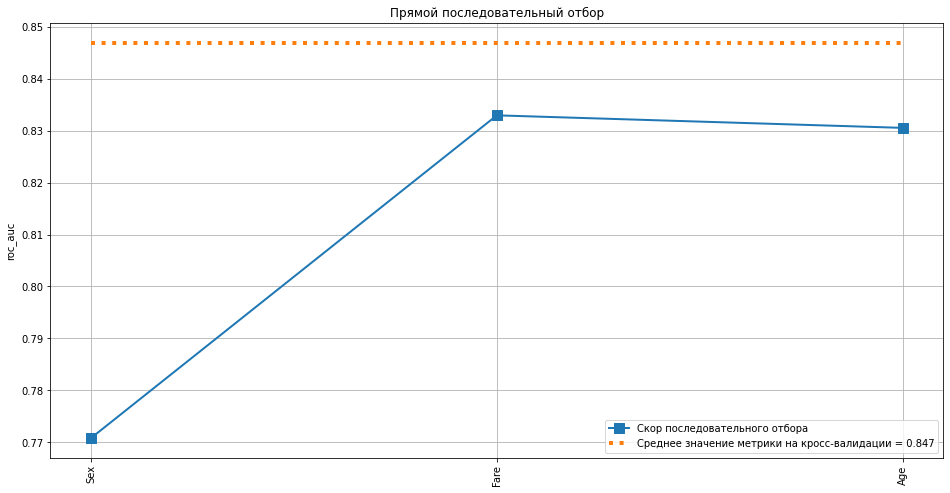

In [36]:
selection.plot_forward(figsize=(16,8))

In [37]:
bselection_res = selection.backward_selection(strat=strat,first_degradation=False)

Определены количественные и категориальные переменные!


1it [00:00,  9.51it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.584313	training's auc: 0.881977	valid_1's binary_logloss: 0.604333	valid_1's auc: 0.803707
[50]	training's binary_logloss: 0.534124	training's auc: 0.890138	valid_1's binary_logloss: 0.569415	valid_1's auc: 0.808983
[75]	training's binary_logloss: 0.496835	training's auc: 0.892917	valid_1's binary_logloss: 0.546755	valid_1's auc: 0.806548
[100]	training's binary_logloss: 0.469893	training's auc: 0.895382	valid_1's binary_logloss: 0.530717	valid_1's auc: 0.806548
[125]	training's binary_logloss: 0.449646	training's auc: 0.898289	valid_1's binary_logloss: 0.521811	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.433322	training's auc: 0.900114	valid_1's binary_logloss: 0.514414	valid_1's auc: 0.802219
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.811

********************** 1 фолд обучен! ******************************


==================== 

2it [00:00,  7.35it/s]

[175]	training's binary_logloss: 0.424676	training's auc: 0.900515	valid_1's binary_logloss: 0.500354	valid_1's auc: 0.834145
[200]	training's binary_logloss: 0.413298	training's auc: 0.902084	valid_1's binary_logloss: 0.496721	valid_1's auc: 0.832251
[225]	training's binary_logloss: 0.402665	training's auc: 0.905103	valid_1's binary_logloss: 0.49753	valid_1's auc: 0.829545
[250]	training's binary_logloss: 0.393341	training's auc: 0.908889	valid_1's binary_logloss: 0.501086	valid_1's auc: 0.82711
BEST ITERATION:  163
roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.583592	training's auc: 0.885959	valid_1's binary_logloss: 0.601347	valid_1's auc: 0.791126
[50]	training's binary_logloss: 0.534302	training's auc: 0.895919	valid_1's binary_logloss: 0.571437	valid_1's auc: 0.784361
[75]	training's binar

4it [00:00,  8.29it/s]

[100]	training's binary_logloss: 0.493193	training's auc: 0.879979	valid_1's binary_logloss: 0.468153	valid_1's auc: 0.898591
[125]	training's binary_logloss: 0.474083	training's auc: 0.88383	valid_1's binary_logloss: 0.447603	valid_1's auc: 0.899834
[150]	training's binary_logloss: 0.459757	training's auc: 0.884161	valid_1's binary_logloss: 0.429714	valid_1's auc: 0.900387
[175]	training's binary_logloss: 0.447762	training's auc: 0.88691	valid_1's binary_logloss: 0.416969	valid_1's auc: 0.898314
[200]	training's binary_logloss: 0.437745	training's auc: 0.887427	valid_1's binary_logloss: 0.405955	valid_1's auc: 0.896933
BEST ITERATION:  117
roc_auc на обучающей выборке: 0.885
roc_auc на проверочной выборке: 0.901

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.589416	training's auc: 0.870818	valid_1's binary_logloss: 0.595452	valid_1's auc: 0.860471
[50]	training's bina

5it [00:00,  7.12it/s]


[300]	training's binary_logloss: 0.396302	training's auc: 0.899818	valid_1's binary_logloss: 0.426187	valid_1's auc: 0.890077
[325]	training's binary_logloss: 0.391291	training's auc: 0.902274	valid_1's binary_logloss: 0.423147	valid_1's auc: 0.891447
[350]	training's binary_logloss: 0.386418	training's auc: 0.904875	valid_1's binary_logloss: 0.422187	valid_1's auc: 0.889803
[375]	training's binary_logloss: 0.38247	training's auc: 0.906482	valid_1's binary_logloss: 0.421838	valid_1's auc: 0.888432
BEST ITERATION:  279
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.893

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  0.846957
Конец обуения кросс-валидации!

Начало жадного отбора факторов Backward Selection!
Удаление признака 0
Определены количественные и категориальные переменные!


1it [00:00,  9.17it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.609082	training's auc: 0.863363	valid_1's binary_logloss: 0.619579	valid_1's auc: 0.795455
[50]	training's binary_logloss: 0.567416	training's auc: 0.863951	valid_1's binary_logloss: 0.58747	valid_1's auc: 0.796537
[75]	training's binary_logloss: 0.536705	training's auc: 0.863695	valid_1's binary_logloss: 0.565268	valid_1's auc: 0.798701
[100]	training's binary_logloss: 0.513059	training's auc: 0.865836	valid_1's binary_logloss: 0.548403	valid_1's auc: 0.803571
[125]	training's binary_logloss: 0.4949	training's auc: 0.86859	valid_1's binary_logloss: 0.535788	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.48042	training's auc: 0.868812	valid_1's binary_logloss: 0.525222	valid_1's auc: 0.800595
[175]	training's binary_logloss: 0.469367	training's auc: 0.869784	valid_1's binary_logloss: 0.518391	valid_1's auc: 0.80276
[200]	training's binary_logloss: 0.460606	training's auc: 0.871574	

2it [00:00,  6.98it/s]

[175]	training's binary_logloss: 0.470997	training's auc: 0.873766	valid_1's binary_logloss: 0.514312	valid_1's auc: 0.823728
[200]	training's binary_logloss: 0.461236	training's auc: 0.874789	valid_1's binary_logloss: 0.508701	valid_1's auc: 0.826434
[225]	training's binary_logloss: 0.453133	training's auc: 0.876221	valid_1's binary_logloss: 0.504473	valid_1's auc: 0.826434
[250]	training's binary_logloss: 0.446153	training's auc: 0.877006	valid_1's binary_logloss: 0.500407	valid_1's auc: 0.828598
[275]	training's binary_logloss: 0.440105	training's auc: 0.878063	valid_1's binary_logloss: 0.498379	valid_1's auc: 0.827516
[300]	training's binary_logloss: 0.434643	training's auc: 0.87849	valid_1's binary_logloss: 0.496244	valid_1's auc: 0.828328
[325]	training's binary_logloss: 0.429939	training's auc: 0.879573	valid_1's binary_logloss: 0.495007	valid_1's auc: 0.823728
BEST ITERATION:  243
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.829

********************** 

4it [00:00,  6.70it/s]

[50]	training's binary_logloss: 0.578255	training's auc: 0.852139	valid_1's binary_logloss: 0.557387	valid_1's auc: 0.898867
[75]	training's binary_logloss: 0.550549	training's auc: 0.854472	valid_1's binary_logloss: 0.523201	valid_1's auc: 0.899143
[100]	training's binary_logloss: 0.529275	training's auc: 0.853785	valid_1's binary_logloss: 0.495845	valid_1's auc: 0.901354
[125]	training's binary_logloss: 0.513346	training's auc: 0.854379	valid_1's binary_logloss: 0.475157	valid_1's auc: 0.903288
[150]	training's binary_logloss: 0.500866	training's auc: 0.856262	valid_1's binary_logloss: 0.459393	valid_1's auc: 0.900525
[175]	training's binary_logloss: 0.491104	training's auc: 0.856924	valid_1's binary_logloss: 0.447537	valid_1's auc: 0.90163
[200]	training's binary_logloss: 0.482245	training's auc: 0.859859	valid_1's binary_logloss: 0.437375	valid_1's auc: 0.900525
BEST ITERATION:  105
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.904

********************** 4 

5it [00:00,  6.89it/s]


[25]	training's binary_logloss: 0.610899	training's auc: 0.853369	valid_1's binary_logloss: 0.615724	valid_1's auc: 0.836897
[50]	training's binary_logloss: 0.570808	training's auc: 0.854899	valid_1's binary_logloss: 0.578196	valid_1's auc: 0.8358
[75]	training's binary_logloss: 0.542024	training's auc: 0.857245	valid_1's binary_logloss: 0.552522	valid_1's auc: 0.83443
[100]	training's binary_logloss: 0.519891	training's auc: 0.85784	valid_1's binary_logloss: 0.532884	valid_1's auc: 0.82881
BEST ITERATION:  11
roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.844

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.8329604384510597
Удаление признака 1
Определены только категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 11.41it/s]

[25]	training's binary_logloss: 0.607059	training's auc: 0.768653	valid_1's binary_logloss: 0.604705	valid_1's auc: 0.778815
[50]	training's binary_logloss: 0.571424	training's auc: 0.768653	valid_1's binary_logloss: 0.567001	valid_1's auc: 0.778815
[75]	training's binary_logloss: 0.549282	training's auc: 0.768653	valid_1's binary_logloss: 0.54317	valid_1's auc: 0.778815
[100]	training's binary_logloss: 0.5354	training's auc: 0.768653	valid_1's binary_logloss: 0.527906	valid_1's auc: 0.778815
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.603428	training's auc: 0.776157	valid_1's binary_logloss: 0.610683	valid_1's auc: 0.748918
[50]	training's binary_logloss: 0.565563	training's auc: 0.776157	valid_1's binary_logloss: 0.578507	valid_1's auc: 0.748918
[75]	training's binary_logl

4it [00:00, 11.82it/s]

roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	valid_1's binary_logloss: 0.608652	valid_1's auc: 0.764803
[50]	training's binary_logloss: 0.568122	training's auc: 0.772132	valid_1's binary_logloss: 0.573518	valid_1's auc: 0.764803
[75]	training's binary_logloss: 0.545269	training's auc: 0.772132	valid_1's binary_logloss: 0.552096	valid_1's auc: 0.764803
[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803


5it [00:00, 11.73it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 0.7707998235433846

Количество отобранных признаков: 1
Метрика до отбора: 0.847 => после отбора: 0.847
Конец жадного отбора факторов Backward Selection!


In [38]:
deep_bselection_res = selection.deep_backward_selection(strat=strat,tol=0.0001)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.584313	training's auc: 0.881977	valid_1's binary_logloss: 0.604333	valid_1's auc: 0.803707
[50]	training's binary_logloss: 0.534124	training's auc: 0.890138	valid_1's binary_logloss: 0.569415	valid_1's auc: 0.808983
[75]	training's binary_logloss: 0.496835	training's auc: 0.892917	valid_1's binary_logloss: 0.546755	valid_1's auc: 0.806548
[100]	training's binary_logloss: 0.469893	training's auc: 0.895382	valid_1's binary_logloss: 0.530717	valid_1's auc: 0.806548


1it [00:00,  3.42it/s]

[125]	training's binary_logloss: 0.449646	training's auc: 0.898289	valid_1's binary_logloss: 0.521811	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.433322	training's auc: 0.900114	valid_1's binary_logloss: 0.514414	valid_1's auc: 0.802219
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.811

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.585877	training's auc: 0.87924	valid_1's binary_logloss: 0.599863	valid_1's auc: 0.827246
[50]	training's binary_logloss: 0.537239	training's auc: 0.885831	valid_1's binary_logloss: 0.566424	valid_1's auc: 0.823458
[75]	training's binary_logloss: 0.502206	training's auc: 0.888006	valid_1's binary_logloss: 0.542905	valid_1's auc: 0.818994


2it [00:00,  3.59it/s]

[100]	training's binary_logloss: 0.475481	training's auc: 0.890163	valid_1's binary_logloss: 0.526334	valid_1's auc: 0.822917
[125]	training's binary_logloss: 0.455834	training's auc: 0.895339	valid_1's binary_logloss: 0.515321	valid_1's auc: 0.830763
[150]	training's binary_logloss: 0.439151	training's auc: 0.897462	valid_1's binary_logloss: 0.505563	valid_1's auc: 0.835768
[175]	training's binary_logloss: 0.424676	training's auc: 0.900515	valid_1's binary_logloss: 0.500354	valid_1's auc: 0.834145
[200]	training's binary_logloss: 0.413298	training's auc: 0.902084	valid_1's binary_logloss: 0.496721	valid_1's auc: 0.832251
[225]	training's binary_logloss: 0.402665	training's auc: 0.905103	valid_1's binary_logloss: 0.49753	valid_1's auc: 0.829545
[250]	training's binary_logloss: 0.393341	training's auc: 0.908889	valid_1's binary_logloss: 0.501086	valid_1's auc: 0.82711
BEST ITERATION:  163
roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.837

********************** 2

4it [00:00,  5.65it/s]

[25]	training's binary_logloss: 0.593405	training's auc: 0.864278	valid_1's binary_logloss: 0.579543	valid_1's auc: 0.881044
[50]	training's binary_logloss: 0.55005	training's auc: 0.872404	valid_1's binary_logloss: 0.532342	valid_1's auc: 0.885327
[75]	training's binary_logloss: 0.517931	training's auc: 0.878588	valid_1's binary_logloss: 0.497215	valid_1's auc: 0.891545
[100]	training's binary_logloss: 0.493193	training's auc: 0.879979	valid_1's binary_logloss: 0.468153	valid_1's auc: 0.898591
[125]	training's binary_logloss: 0.474083	training's auc: 0.88383	valid_1's binary_logloss: 0.447603	valid_1's auc: 0.899834
[150]	training's binary_logloss: 0.459757	training's auc: 0.884161	valid_1's binary_logloss: 0.429714	valid_1's auc: 0.900387
[175]	training's binary_logloss: 0.447762	training's auc: 0.88691	valid_1's binary_logloss: 0.416969	valid_1's auc: 0.898314
[200]	training's binary_logloss: 0.437745	training's auc: 0.887427	valid_1's binary_logloss: 0.405955	valid_1's auc: 0.89693

5it [00:01,  4.95it/s]


[175]	training's binary_logloss: 0.435165	training's auc: 0.890639	valid_1's binary_logloss: 0.45347	valid_1's auc: 0.889391
[200]	training's binary_logloss: 0.425157	training's auc: 0.89205	valid_1's binary_logloss: 0.445072	valid_1's auc: 0.889529
[225]	training's binary_logloss: 0.41652	training's auc: 0.893699	valid_1's binary_logloss: 0.438526	valid_1's auc: 0.888706
[250]	training's binary_logloss: 0.40951	training's auc: 0.895806	valid_1's binary_logloss: 0.434002	valid_1's auc: 0.890762
[275]	training's binary_logloss: 0.403208	training's auc: 0.897107	valid_1's binary_logloss: 0.429339	valid_1's auc: 0.891173
[300]	training's binary_logloss: 0.396302	training's auc: 0.899818	valid_1's binary_logloss: 0.426187	valid_1's auc: 0.890077
[325]	training's binary_logloss: 0.391291	training's auc: 0.902274	valid_1's binary_logloss: 0.423147	valid_1's auc: 0.891447
[350]	training's binary_logloss: 0.386418	training's auc: 0.904875	valid_1's binary_logloss: 0.422187	valid_1's auc: 0.889

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.609082	training's auc: 0.863363	valid_1's binary_logloss: 0.619579	valid_1's auc: 0.795455
[50]	training's binary_logloss: 0.567416	training's auc: 0.863951	valid_1's binary_logloss: 0.58747	valid_1's auc: 0.796537
[75]	training's binary_logloss: 0.536705	training's auc: 0.863695	valid_1's binary_logloss: 0.565268	valid_1's auc: 0.798701
[100]	training's binary_logloss: 0.513059	training's auc: 0.865836	valid_1's binary_logloss: 0.548403	valid_1's auc: 0.803571
[125]	training's binary_logloss: 0.4949	training's auc: 0.86859	valid_1's binary_logloss: 0.535788	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.48042	training's auc: 0.868812	valid_1's binary_logloss: 0.525222	valid_1's auc: 0.800595
[175]	training's binary_logloss: 0.469367	training's auc: 0.869784	valid_1's binary_logloss: 0.518391	valid_1's auc: 0.80276
[200]	training's binary_logloss: 0.460606	training's auc: 0.871574	

1it [00:00,  4.61it/s]

BEST ITERATION:  103
roc_auc на обучающей выборке: 0.866
roc_auc на проверочной выборке: 0.804

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.610394	training's auc: 0.866552	valid_1's binary_logloss: 0.622115	valid_1's auc: 0.814935
[50]	training's binary_logloss: 0.569365	training's auc: 0.867694	valid_1's binary_logloss: 0.589244	valid_1's auc: 0.818452
[75]	training's binary_logloss: 0.538938	training's auc: 0.868308	valid_1's binary_logloss: 0.565768	valid_1's auc: 0.817911
[100]	training's binary_logloss: 0.5153	training's auc: 0.869929	valid_1's binary_logloss: 0.546735	valid_1's auc: 0.824675
[125]	training's binary_logloss: 0.497418	training's auc: 0.869622	valid_1's binary_logloss: 0.532977	valid_1's auc: 0.824946
[150]	training's binary_logloss: 0.483092	training's auc: 0.870048	valid_1's binary_logloss: 0.522157	valid_1's auc: 0.822511


2it [00:00,  5.43it/s]

[175]	training's binary_logloss: 0.470997	training's auc: 0.873766	valid_1's binary_logloss: 0.514312	valid_1's auc: 0.823728
[200]	training's binary_logloss: 0.461236	training's auc: 0.874789	valid_1's binary_logloss: 0.508701	valid_1's auc: 0.826434
[225]	training's binary_logloss: 0.453133	training's auc: 0.876221	valid_1's binary_logloss: 0.504473	valid_1's auc: 0.826434
[250]	training's binary_logloss: 0.446153	training's auc: 0.877006	valid_1's binary_logloss: 0.500407	valid_1's auc: 0.828598
[275]	training's binary_logloss: 0.440105	training's auc: 0.878063	valid_1's binary_logloss: 0.498379	valid_1's auc: 0.827516
[300]	training's binary_logloss: 0.434643	training's auc: 0.87849	valid_1's binary_logloss: 0.496244	valid_1's auc: 0.828328
[325]	training's binary_logloss: 0.429939	training's auc: 0.879573	valid_1's binary_logloss: 0.495007	valid_1's auc: 0.823728
BEST ITERATION:  243
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.829

********************** 

4it [00:00,  7.82it/s]

[100]	training's binary_logloss: 0.529275	training's auc: 0.853785	valid_1's binary_logloss: 0.495845	valid_1's auc: 0.901354
[125]	training's binary_logloss: 0.513346	training's auc: 0.854379	valid_1's binary_logloss: 0.475157	valid_1's auc: 0.903288
[150]	training's binary_logloss: 0.500866	training's auc: 0.856262	valid_1's binary_logloss: 0.459393	valid_1's auc: 0.900525
[175]	training's binary_logloss: 0.491104	training's auc: 0.856924	valid_1's binary_logloss: 0.447537	valid_1's auc: 0.90163
[200]	training's binary_logloss: 0.482245	training's auc: 0.859859	valid_1's binary_logloss: 0.437375	valid_1's auc: 0.900525
BEST ITERATION:  105
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.610899	training's auc: 0.853369	valid_1's binary_logloss: 0.615724	valid_1's auc: 0.836897
[50]	training's bin

5it [00:00,  7.69it/s]


[100]	training's binary_logloss: 0.519891	training's auc: 0.85784	valid_1's binary_logloss: 0.532884	valid_1's auc: 0.82881
BEST ITERATION:  11
roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.844

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.8329604384510597
Метрика модели со всеми признаками=0.8469565475584512
Разница метрики =0.013996109107391463
Сохраняем:  Age
Проверяемый признак: Fare
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.622264	training's auc: 0.839154	valid_1's binary_logloss: 0.636951	valid_1's auc: 0.73566
[50]	training's binary_logloss: 0.587425	training's auc: 0.842719	valid_1's binary_logloss: 0.61411	valid_1's auc: 0.727679
[75]	training's binary_logloss: 0.561641	training's auc: 0.84103	valid_1's binary_logloss: 0.59849	valid_1's auc: 0.727137
[100]	training's binary_logloss: 0.540257	training's auc: 0.843631	valid_1's binary_logloss: 0.585426	valid_1's auc: 0.722808
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.838
roc_auc на проверочной выборке: 0.748

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.626181	training's auc: 0.820642	valid_1's binary_logloss: 0.629184	valid_1's auc: 0.790855
[50]	training's binary_logloss: 0.594708	training's auc: 0.822706	valid_1's binary_logloss: 0

2it [00:00, 10.48it/s]

BEST ITERATION:  125
roc_auc на обучающей выборке: 0.827
roc_auc на проверочной выборке: 0.808

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.625281	training's auc: 0.827882	valid_1's binary_logloss: 0.629963	valid_1's auc: 0.812229
[50]	training's binary_logloss: 0.592906	training's auc: 0.827933	valid_1's binary_logloss: 0.600998	valid_1's auc: 0.813041
[75]	training's binary_logloss: 0.569413	training's auc: 0.828044	valid_1's binary_logloss: 0.579916	valid_1's auc: 0.812906
[100]	training's binary_logloss: 0.550109	training's auc: 0.828146	valid_1's binary_logloss: 0.56263	valid_1's auc: 0.8102
BEST ITERATION:  7
roc_auc на обучающей выборке: 0.827
roc_auc на проверочной выборке: 0.820

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00, 11.80it/s]

[25]	training's binary_logloss: 0.628144	training's auc: 0.825241	valid_1's binary_logloss: 0.624239	valid_1's auc: 0.82205
[50]	training's binary_logloss: 0.59781	training's auc: 0.8248	valid_1's binary_logloss: 0.591775	valid_1's auc: 0.82205
[75]	training's binary_logloss: 0.575436	training's auc: 0.8248	valid_1's binary_logloss: 0.568235	valid_1's auc: 0.82205
[100]	training's binary_logloss: 0.557213	training's auc: 0.823723	valid_1's binary_logloss: 0.548023	valid_1's auc: 0.820669
[125]	training's binary_logloss: 0.543489	training's auc: 0.825385	valid_1's binary_logloss: 0.532887	valid_1's auc: 0.823017
[150]	training's binary_logloss: 0.532112	training's auc: 0.827379	valid_1's binary_logloss: 0.519649	valid_1's auc: 0.823017
BEST ITERATION:  61
roc_auc на обучающей выборке: 0.826
roc_auc на проверочной выборке: 0.825

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_loglos

5it [00:00, 11.35it/s]


roc_auc на обучающей выборке: 0.835
roc_auc на проверочной выборке: 0.766

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.7936054928181189
Метрика модели со всеми признаками=0.8469565475584512
Разница метрики =0.053351054740332304
Сохраняем:  Fare
Проверяемый признак: Sex
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.632907	training's auc: 0.799146	valid_1's binary_logloss: 0.646111	valid_1's auc: 0.697917
[50]	training's binary_logloss: 0.608836	training's auc: 0.802659	valid_1's binary_logloss: 0.633233	valid_1's auc: 0.694399
[75]	training's binary_logloss: 0.589526	training's auc: 0.804023	valid_1's binary_logloss: 0.622702	valid_1's auc: 0.69724
[100]	training's binary_logloss: 0.574635	training's auc: 0.807528	valid_1's binary_logloss: 0.616288	valid_1's auc: 0.705087
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.795
roc_auc на проверочной выборке: 0.712

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.633189	training's auc: 0.812584	valid_1's binary_logloss: 0.650004	valid_1's auc: 0.665314
[50]	training's binary_logloss: 0.609174	training's auc: 0.812925	valid_1's binary_logloss

2it [00:00,  9.55it/s]

roc_auc на обучающей выборке: 0.825
roc_auc на проверочной выборке: 0.693

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.633664	training's auc: 0.800015	valid_1's binary_logloss: 0.653479	valid_1's auc: 0.610254
[50]	training's binary_logloss: 0.610366	training's auc: 0.80248	valid_1's binary_logloss: 0.645814	valid_1's auc: 0.613907
[75]	training's binary_logloss: 0.591468	training's auc: 0.804373	valid_1's binary_logloss: 0.639277	valid_1's auc: 0.618506
[100]	training's binary_logloss: 0.576947	training's auc: 0.806615	valid_1's binary_logloss: 0.634244	valid_1's auc: 0.624594
BEST ITERATION:  2


4it [00:00, 12.75it/s]

roc_auc на обучающей выборке: 0.795
roc_auc на проверочной выборке: 0.640

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.635426	training's auc: 0.78142	valid_1's binary_logloss: 0.636546	valid_1's auc: 0.768721
[50]	training's binary_logloss: 0.612564	training's auc: 0.783914	valid_1's binary_logloss: 0.617236	valid_1's auc: 0.766648
[75]	training's binary_logloss: 0.594045	training's auc: 0.786297	valid_1's binary_logloss: 0.601995	valid_1's auc: 0.768444
[100]	training's binary_logloss: 0.580062	training's auc: 0.788995	valid_1's binary_logloss: 0.592371	valid_1's auc: 0.766786
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.787

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.635336	training's auc: 0.78585	vali

5it [00:00, 10.64it/s]

[200]	training's binary_logloss: 0.549065	training's auc: 0.794826	valid_1's binary_logloss: 0.575216	valid_1's auc: 0.744106
[225]	training's binary_logloss: 0.543829	training's auc: 0.796321	valid_1's binary_logloss: 0.571472	valid_1's auc: 0.743284
[250]	training's binary_logloss: 0.539639	training's auc: 0.796474	valid_1's binary_logloss: 0.568966	valid_1's auc: 0.739309
[275]	training's binary_logloss: 0.535885	training's auc: 0.796704	valid_1's binary_logloss: 0.566587	valid_1's auc: 0.739309
BEST ITERATION:  199
roc_auc на обучающей выборке: 0.795
roc_auc на проверочной выборке: 0.746

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.7156069044104459
Метрика модели со всеми признаками=0.8469565475584512
Разница метрики =0.13134964314800524
Сохраняем:  Sex
Общее количество признаков для сохранения:  3

Конец жадного отбора факторов Backward Selection!


In [39]:
# Функция report (на вход можно дополнительно указать отложенные множества)
## На выходе получаем таблицу из используемых методов отбора, количестве отобранных факторов, метрики на кросс валидации и метрики на отложенном множестве

selection.report(X_valid,y_valid)

Соло модель с факторами кросс - валидации
Определены количественные и категориальные переменные!

Соло модель с факторами forward selection
Определены количественные и категориальные переменные!

Соло модель с факторами backward selection
Определены количественные и категориальные переменные!

Соло модель с факторами deep backward selection
Определены количественные и категориальные переменные!



Метод отбора  Количество факторов  \
0          Mean_importance                    3   
1        Forward_selection                    3   
2       Backward_selection                    3   
3  Deep_backward_selection                    3   

   Метрика roc_auc на кросс-валидации  Метрика roc_auc на отложенном множестве  
0                            0.846957                                   0.7981  
1                            0.830548                                   0.8129  
2                            0.846957                                   0.7981  
3                            0.846957                                   0.8129

In [40]:
fselection_res['features_stack']

['Sex', 'Fare', 'Age']

In [41]:
bselection_res['features_stack']

['Sex', 'Fare', 'Age']

In [42]:
deep_bselection_res['features_stack']

['Sex', 'Fare', 'Age']

In [43]:
# Обновляем факторы, выбираем Backward selection

features = fselection_res['features_stack']
num_columns = list(filter(lambda x: x in features, num_columns))
cat_columns = list(filter(lambda x: x in features, cat_columns))

print(len(features),len(num_columns),len(cat_columns))

3 2 1


In [44]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


## Подбор гиперпараметров с финальными факторами

In [45]:
import optuna
from optuna.samplers import TPESampler

# импортируем функции для визуализации
from optuna.visualization import plot_slice, plot_contour, plot_optimization_history

In [46]:
def create_model(trial):
    
    param = {'learning_rate':trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
             'n_estimators':1000,
             'random_state':42,
             'n_jobs':-1,
             'max_depth': trial.suggest_int("max_depth", 1, 9),
             'subsample':trial.suggest_loguniform("subsample", 0.4, 1.0),
             'colsample_bytree':trial.suggest_loguniform("colsample_bytree", 0.4, 1.0),
             'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
        
    fit_params = {
        'early_stopping_rounds':100, 
        'eval_metric':['logloss', 'auc'],
        'verbose':False}

    # создаем экземпляр класса XGBClassifier
    lgb_model = lgb.LGBMClassifier(**param)
    
    model = AutoTrees(
        main_estimator = lgb_model, 
        main_fit_params = fit_params,
        main_prep_pipe = prep_pipe,
        main_features = num_columns+cat_columns,

        X_train=X_train,
        y_train=y_train,
        main_metric='roc_auc',
        model_type = 'lightboost')
    
    return model
    
def objective(trial):
    my_model = create_model(trial)
    my_model.model_fit_cv(strat=strat)
    return my_model.get_mean_cv_scores()

sampler = TPESampler(seed=13)

In [47]:
%%time

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=15)

[I 2023-04-03 18:21:21,086] A new study created in memory with name: no-name-90d76473-789d-47e8-b2d1-d3d04da71e80
0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  44
roc_auc на обучающей выборке: 0.870
roc_auc на проверочной выборке: 0.803

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


4it [00:00, 11.15it/s]

BEST ITERATION:  189
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.816

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  31
roc_auc на обучающей выборке: 0.862
roc_auc на проверочной выборке: 0.816

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.831
roc_auc на проверочной выборке: 0.883

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 10.80it/s]
[I 2023-04-03 18:21:21,555] Trial 0 finished with value: 0.8391575529733425 and parameters: {'learning_rate': 0.016657862946854292, 'max_depth': 3, 'subsample': 0.8512818965985735, 'colsample_bytree': 0.9691036640278632, 'lambda_l1': 0.6036829515606789, 'reg_lambda': 4.242227738456316e-05}. Best is trial 0 with value: 0.8391575529733425.


BEST ITERATION:  16
roc_auc на обучающей выборке: 0.849
roc_auc на проверочной выборке: 0.878

********************** 5 фолд обучен! ******************************




1it [00:00,  9.38it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.810

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.90it/s]

BEST ITERATION:  68
roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.836

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.791

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  8.35it/s]

BEST ITERATION:  113
roc_auc на обучающей выборке: 0.872
roc_auc на проверочной выборке: 0.895

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.39it/s]
[I 2023-04-03 18:21:22,344] Trial 1 finished with value: 0.8425446777000529 and parameters: {'learning_rate': 0.0007453147259023178, 'max_depth': 7, 'subsample': 0.7200847463571936, 'colsample_bytree': 0.7751396130953855, 'lambda_l1': 1.9067431410286563e-08, 'reg_lambda': 2.4411573130002195e-06}. Best is trial 1 with value: 0.8425446777000529.


BEST ITERATION:  411
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.881

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.810

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  8.22it/s]

BEST ITERATION:  131
roc_auc на обучающей выборке: 0.884
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.791

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  8.67it/s]
[I 2023-04-03 18:21:22,927] Trial 2 finished with value: 0.8388984580648915 and parameters: {'learning_rate': 2.938325709282276e-08, 'max_depth': 8, 'subsample': 0.5629029522615503, 'colsample_bytree': 0.7457593225505744, 'lambda_l1': 1.1226376280587474e-06, 'reg_lambda': 6.034617129907733e-06}. Best is trial 1 with value: 0.8425446777000529.


BEST ITERATION:  113
roc_auc на обучающей выборке: 0.872
roc_auc на проверочной выборке: 0.895

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  40
roc_auc на обучающей выборке: 0.873
roc_auc на проверочной выборке: 0.864

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  11
roc_auc на обучающей выборке: 0.870
roc_auc на проверочной выборке: 0.799

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 13.20it/s]

BEST ITERATION:  7
roc_auc на обучающей выборке: 0.868
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


4it [00:00, 11.75it/s]

BEST ITERATION:  77
roc_auc на обучающей выборке: 0.865
roc_auc на проверочной выборке: 0.814

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  33
roc_auc на обучающей выборке: 0.855
roc_auc на проверочной выборке: 0.907

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 12.17it/s]
[I 2023-04-03 18:21:23,344] Trial 3 finished with value: 0.834819201655008 and parameters: {'learning_rate': 1.18932941630388e-08, 'max_depth': 4, 'subsample': 0.9544266077751685, 'colsample_bytree': 0.4883944554330421, 'lambda_l1': 3.5903015869521766e-06, 'reg_lambda': 0.2198766380977821}. Best is trial 1 with value: 0.8425446777000529.


BEST ITERATION:  15
roc_auc на обучающей выборке: 0.859
roc_auc на проверочной выборке: 0.825

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


2it [00:00, 15.99it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.776
roc_auc на проверочной выборке: 0.749

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00, 16.02it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 16.03it/s]
[I 2023-04-03 18:21:23,663] Trial 4 finished with value: 0.7707998235433846 and parameters: {'learning_rate': 1.7998210693616812e-08, 'max_depth': 1, 'subsample': 0.712351181072161, 'colsample_bytree': 0.8908104858367459, 'lambda_l1': 1.1741561533371617e-08, 'reg_lambda': 0.009388968801538531}. Best is trial 1 with value: 0.8425446777000529.


BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  124
roc_auc на обучающей выборке: 0.848
roc_auc на проверочной выборке: 0.795

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 11.34it/s]

BEST ITERATION:  124
roc_auc на обучающей выборке: 0.841
roc_auc на проверочной выборке: 0.819

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  111
roc_auc на обучающей выборке: 0.846
roc_auc на проверочной выборке: 0.797

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00, 11.98it/s]

BEST ITERATION:  78
roc_auc на обучающей выборке: 0.825
roc_auc на проверочной выборке: 0.890

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 12.10it/s]
[I 2023-04-03 18:21:24,082] Trial 5 finished with value: 0.8302687176112429 and parameters: {'learning_rate': 0.03182213897091778, 'max_depth': 1, 'subsample': 0.7299444870314954, 'colsample_bytree': 0.6378459401959322, 'lambda_l1': 6.903465073374914e-05, 'reg_lambda': 0.44115698447977153}. Best is trial 1 with value: 0.8425446777000529.


BEST ITERATION:  47
roc_auc на обучающей выборке: 0.826
roc_auc на проверочной выборке: 0.851

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  8.35it/s]

BEST ITERATION:  8
roc_auc на обучающей выборке: 0.863
roc_auc на проверочной выборке: 0.800

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  8
roc_auc на обучающей выборке: 0.859
roc_auc на проверочной выборке: 0.816

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  8


3it [00:00,  9.59it/s]

roc_auc на обучающей выборке: 0.858
roc_auc на проверочной выборке: 0.807

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  9.83it/s]
[I 2023-04-03 18:21:24,598] Trial 6 finished with value: 0.8325819232559155 and parameters: {'learning_rate': 1.000221691111536e-08, 'max_depth': 3, 'subsample': 0.7682204596696642, 'colsample_bytree': 0.5385476994612127, 'lambda_l1': 1.6442613601572179e-06, 'reg_lambda': 0.0036606956269090826}. Best is trial 1 with value: 0.8425446777000529.


BEST ITERATION:  105
roc_auc на обучающей выборке: 0.840
roc_auc на проверочной выборке: 0.884

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  8
roc_auc на обучающей выборке: 0.848
roc_auc на проверочной выборке: 0.855

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.932
roc_auc на проверочной выборке: 0.828

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 11.58it/s]

BEST ITERATION:  23
roc_auc на обучающей выборке: 0.892
roc_auc на проверочной выборке: 0.821

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  29
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборке: 0.811

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00, 11.76it/s]

BEST ITERATION:  27
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.906

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 11.40it/s]
[I 2023-04-03 18:21:25,043] Trial 7 finished with value: 0.8495964963787614 and parameters: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}. Best is trial 7 with value: 0.8495964963787614.


BEST ITERATION:  86
roc_auc на обучающей выборке: 0.931
roc_auc на проверочной выборке: 0.881

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


3it [00:00,  8.08it/s]

BEST ITERATION:  249
roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.795

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  189
roc_auc на обучающей выборке: 0.841
roc_auc на проверочной выборке: 0.819

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  48
roc_auc на обучающей выборке: 0.840
roc_auc на проверочной выборке: 0.793

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  8.90it/s]
[I 2023-04-03 18:21:25,611] Trial 8 finished with value: 0.8290402474997938 and parameters: {'learning_rate': 0.01510184739708474, 'max_depth': 1, 'subsample': 0.7500335556862139, 'colsample_bytree': 0.6610504713632539, 'lambda_l1': 1.2702477141773656e-07, 'reg_lambda': 6.166315669959719e-08}. Best is trial 7 with value: 0.8495964963787614.


BEST ITERATION:  33
roc_auc на обучающей выборке: 0.817
roc_auc на проверочной выборке: 0.887

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  92
roc_auc на обучающей выборке: 0.826
roc_auc на проверочной выборке: 0.851

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  8
roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.796

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 13.91it/s]

BEST ITERATION:  8
roc_auc на обучающей выборке: 0.838
roc_auc на проверочной выборке: 0.813

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  8


4it [00:00, 14.60it/s]

roc_auc на обучающей выборке: 0.842
roc_auc на проверочной выборке: 0.795

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  8
roc_auc на обучающей выборке: 0.824
roc_auc на проверочной выборке: 0.889

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  8


5it [00:00, 14.57it/s]
[I 2023-04-03 18:21:25,961] Trial 9 finished with value: 0.8279015660524619 and parameters: {'learning_rate': 9.214522664676005e-07, 'max_depth': 2, 'subsample': 0.9344374649187448, 'colsample_bytree': 0.7459350034069333, 'lambda_l1': 7.966569972905611e-07, 'reg_lambda': 0.00035569848911218646}. Best is trial 7 with value: 0.8495964963787614.


roc_auc на обучающей выборке: 0.832
roc_auc на проверочной выборке: 0.846

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  22
roc_auc на обучающей выборке: 0.931
roc_auc на проверочной выборке: 0.838

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 10.73it/s]

BEST ITERATION:  7
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.815

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.822
roc_auc на проверочной выборке: 0.796

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00, 11.56it/s]

BEST ITERATION:  30
roc_auc на обучающей выборке: 0.926
roc_auc на проверочной выборке: 0.897

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 11.19it/s]
[I 2023-04-03 18:21:26,444] Trial 10 finished with value: 0.8451213033187415 and parameters: {'learning_rate': 0.6126551151105641, 'max_depth': 6, 'subsample': 0.4052782322125098, 'colsample_bytree': 0.4030535985522025, 'lambda_l1': 0.035478390089957845, 'reg_lambda': 1.1103028873460876e-08}. Best is trial 7 with value: 0.8495964963787614.


BEST ITERATION:  38
roc_auc на обучающей выборке: 0.932
roc_auc на проверочной выборке: 0.880

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  21
roc_auc на обучающей выборке: 0.941
roc_auc на проверочной выборке: 0.852

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 11.36it/s]

BEST ITERATION:  3
roc_auc на обучающей выборке: 0.820
roc_auc на проверочной выборке: 0.792

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.822
roc_auc на проверочной выборке: 0.796

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00, 10.94it/s]

BEST ITERATION:  10
roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.893

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  22


5it [00:00, 10.90it/s]
[I 2023-04-03 18:21:26,937] Trial 11 finished with value: 0.8418196270414914 and parameters: {'learning_rate': 0.908846607002455, 'max_depth': 6, 'subsample': 0.40477111067546134, 'colsample_bytree': 0.40196055773967254, 'lambda_l1': 0.01049576427499153, 'reg_lambda': 1.1186354772342221e-08}. Best is trial 7 with value: 0.8495964963787614.


roc_auc на обучающей выборке: 0.933
roc_auc на проверочной выборке: 0.876

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  9.68it/s]

BEST ITERATION:  41
roc_auc на обучающей выборке: 0.926
roc_auc на проверочной выборке: 0.830

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.91it/s]

BEST ITERATION:  7
roc_auc на обучающей выборке: 0.882
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


4it [00:00,  9.02it/s]

BEST ITERATION:  10
roc_auc на обучающей выборке: 0.898
roc_auc на проверочной выборке: 0.803

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  35
roc_auc на обучающей выборке: 0.912
roc_auc на проверочной выборке: 0.893

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  109


5it [00:00,  8.71it/s]
[I 2023-04-03 18:21:27,544] Trial 12 finished with value: 0.8461730592802121 and parameters: {'learning_rate': 0.31963140236257614, 'max_depth': 6, 'subsample': 0.5148871743376601, 'colsample_bytree': 0.4098988603369341, 'lambda_l1': 0.0015856440736163775, 'reg_lambda': 1.7315872236632385e-07}. Best is trial 7 with value: 0.8495964963787614.


roc_auc на обучающей выборке: 0.934
roc_auc на проверочной выборке: 0.875

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  35
roc_auc на обучающей выборке: 0.882
roc_auc на проверочной выборке: 0.797

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 10.37it/s]

BEST ITERATION:  12
roc_auc на обучающей выборке: 0.880
roc_auc на проверочной выборке: 0.836

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  12
roc_auc на обучающей выборке: 0.882
roc_auc на проверочной выборке: 0.822

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  8.35it/s]

BEST ITERATION:  47
roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.911

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  8.98it/s]
[I 2023-04-03 18:21:28,135] Trial 13 finished with value: 0.8437530752655332 and parameters: {'learning_rate': 0.00011442866132772038, 'max_depth': 9, 'subsample': 0.544871127088014, 'colsample_bytree': 0.49083083088765284, 'lambda_l1': 0.00021184242964692173, 'reg_lambda': 3.263769512886426e-06}. Best is trial 7 with value: 0.8495964963787614.


BEST ITERATION:  15
roc_auc на обучающей выборке: 0.876
roc_auc на проверочной выборке: 0.852

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  8.12it/s]

BEST ITERATION:  175
roc_auc на обучающей выборке: 0.916
roc_auc на проверочной выборке: 0.820

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  34


3it [00:00, 11.07it/s]

roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.830

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  18
roc_auc на обучающей выборке: 0.882
roc_auc на проверочной выборке: 0.811

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  33
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.898

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  8.63it/s]
[I 2023-04-03 18:21:28,748] Trial 14 finished with value: 0.8471465853342253 and parameters: {'learning_rate': 0.08311031422638661, 'max_depth': 4, 'subsample': 0.49302930533479217, 'colsample_bytree': 0.4638721336980811, 'lambda_l1': 0.00013006376349398004, 'reg_lambda': 2.2847376178616772e-07}. Best is trial 7 with value: 0.8495964963787614.


BEST ITERATION:  471
roc_auc на обучающей выборке: 0.927
roc_auc на проверочной выборке: 0.877

********************** 5 фолд обучен! ******************************


CPU times: user 1min, sys: 54 s, total: 1min 54s
Wall time: 7.66 s


In [48]:
print(f'Параметры до подбора: {params}')
print('==========')
best_params = study.best_params
print(f'Параметры после подбора: {best_params}')

Параметры до подбора: {'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42}
Параметры после подбора: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}


In [49]:
# Обновление параметров

params.update(best_params)
print(f'Проверка обновления параметров: {params}')

Проверка обновления параметров: {'learning_rate': 0.22305603868123763, 'n_estimators': 1000, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'max_depth': 3, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}


In [50]:
fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':0}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [51]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [52]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.932
roc_auc на проверочной выборке: 0.828

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


2it [00:00, 12.01it/s]

BEST ITERATION:  23
roc_auc на обучающей выборке: 0.892
roc_auc на проверочной выборке: 0.821

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  29
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборке: 0.811

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


4it [00:00,  8.32it/s]

BEST ITERATION:  27
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.906

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  86


5it [00:00,  7.67it/s]

roc_auc на обучающей выборке: 0.931
roc_auc на проверочной выборке: 0.881

********************** 5 фолд обучен! ******************************




In [53]:
model.get_mean_cv_scores()

0.8495964963787614

# Обучение финальной модели и калибровка 

In [54]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=None,
                    model_final=None,
    
                    base_pipe=base_pipe,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type='lightboost',
                    model_params=params,
                    task_type='classification')

In [55]:
# Обучение финальной соло модели

final_model.fit(X_train,y_train)

Определены количественные и категориальные переменные!
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


'Пайплайн и модель обучены!'

### Отрисовка метрики баланса классов и получение скоров

In [56]:
# Если хотим проскорить одну из выборок

train_scores = final_model.predict(X_train)
val_scores = final_model.predict(X_valid)

Всего записей в выборке:  623
Всего таргетов в выборке:  239


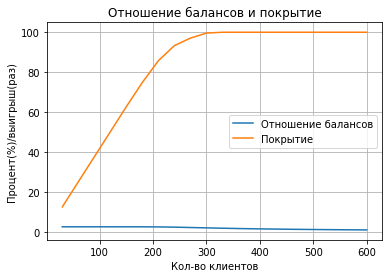

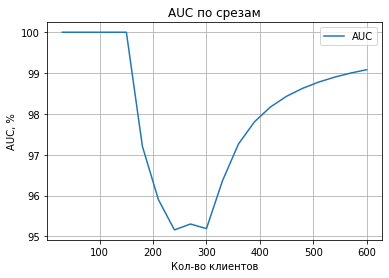

start_bucket  end_bucket  turget_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          30                30      100.000000     12.552301   
1              0          60                60      100.000000     25.104603   
2              0          90                90      100.000000     37.656904   
3              0         120               120      100.000000     50.209205   
4              0         150               150      100.000000     62.761506   
5              0         180               179       99.444444     74.895397   
6              0         210               205       97.619048     85.774059   
7              0         240               223       92.916667     93.305439   
8              0         270               232       85.925926     97.071130   
9              0         300               238       79.333333     99.581590   
10             0         330               239       72.424242    100.000000   
11             0         360               239       66.388889    100.000000   
12             0         390               239       61.282051    100.000000   
13             0         420               239       56.904762    100.000000   
14             0         450               239       53.111111    100.000000   
15             0         480               239       49.791667    100.000000   
16             0         510               239       46.862745    100.000000   
17             0         540               239       44.259259    100.000000   
18             0         570               239       41.929825    100.000000   
19             0         600               239       39.833333    100.000000   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.362761             2.606695  100.000000  
1      38.362761             2.606695  100.000000  
2      38.362761             2.606695  100.000000  
3      38.362761             2.606695  100.000000  
4      38.362761             2.606695  100.000000  
5      38.362761             2.592213   97.206704  
6      38.362761             2.544630   95.902439  
7      38.362761             2.422054   95.159588  
8      38.362761             2.239826   95.303993  
9      38.362761             2.067978   95.191786  
10     38.362761             1.887879   96.363051  
11     38.362761             1.730556   97.264774  
12     38.362761             1.597436   97.808196  
13     38.362761             1.483333   98.171479  
14     38.362761             1.384444   98.431458  
15     38.362761             1.297917   98.626712  
16     38.362761             1.221569   98.778737  
17     38.362761             1.153704   98.900457  
18     38.362761             1.092982   99.000114  
19     38.362761             1.038333   99.083207

In [57]:
# Метрика отношение балансов для трейна

tr_table_cover_1 = final_model.balance_cover_1(X_train, y_train, step=30, end=600)
tr_table_cover_1

Всего записей в выборке:  268
Всего таргетов в выборке:  103


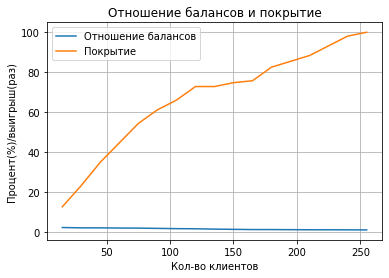

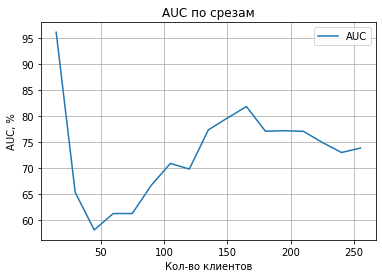

start_bucket  end_bucket  turget_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          15                13       86.666667     12.621359   
1              0          30                24       80.000000     23.300971   
2              0          45                36       80.000000     34.951456   
3              0          60                46       76.666667     44.660194   
4              0          75                56       74.666667     54.368932   
5              0          90                63       70.000000     61.165049   
6              0         105                68       64.761905     66.019417   
7              0         120                75       62.500000     72.815534   
8              0         135                75       55.555556     72.815534   
9              0         150                77       51.333333     74.757282   
10             0         165                78       47.272727     75.728155   
11             0         180                85       47.222222     82.524272   
12             0         195                88       45.128205     85.436893   
13             0         210                91       43.333333     88.349515   
14             0         225                96       42.666667     93.203883   
15             0         240               101       42.083333     98.058252   
16             0         255               103       40.392157    100.000000   

    base_bal (%)  bucket_bal/base_bal        auc  
0      38.432836             2.255016  96.153846  
1      38.432836             2.081553  65.277778  
2      38.432836             2.081553  58.024691  
3      38.432836             1.994822  61.180124  
4      38.432836             1.942783  61.184211  
5      38.432836             1.821359  66.637272  
6      38.432836             1.685067  70.846582  
7      38.432836             1.626214  69.762963  
8      38.432836             1.445523  77.322222  
9      38.432836             1.335663  79.603273  
10     38.432836             1.230009  81.822871  
11     38.432836             1.228695  77.065015  
12     38.432836             1.174210  77.155905  
13     38.432836             1.127508  77.033890  
14     38.432836             1.110162  74.878876  
15     38.432836             1.094984  72.953914  
16     38.432836             1.050980  73.824732

In [58]:
# Метрика отношение балансов для валидации

te_table_cover_1 = final_model.balance_cover_1(X_valid, y_valid, step=15, end=250)
te_table_cover_1

#### Процентность таргета в бакетах

Всего записей в выборке:  623
Всего таргетов в выборке:  239


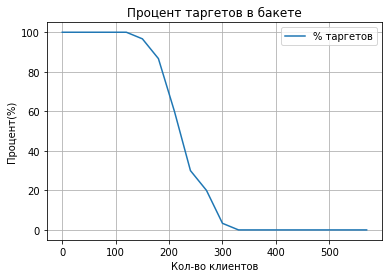

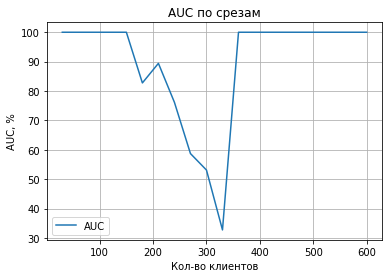

start_bucket  end_bucket  target_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          30                30      100.000000     12.552301   
1             30          60                30      100.000000     12.552301   
2             60          90                30      100.000000     12.552301   
3             90         120                30      100.000000     12.552301   
4            120         150                30      100.000000     12.552301   
5            150         180                29       96.666667     12.133891   
6            180         210                26       86.666667     10.878661   
7            210         240                18       60.000000      7.531381   
8            240         270                 9       30.000000      3.765690   
9            270         300                 6       20.000000      2.510460   
10           300         330                 1        3.333333      0.418410   
11           330         360                 0        0.000000      0.000000   
12           360         390                 0        0.000000      0.000000   
13           390         420                 0        0.000000      0.000000   
14           420         450                 0        0.000000      0.000000   
15           450         480                 0        0.000000      0.000000   
16           480         510                 0        0.000000      0.000000   
17           510         540                 0        0.000000      0.000000   
18           540         570                 0        0.000000      0.000000   
19           570         600                 0        0.000000      0.000000   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.362761             2.606695  100.000000  
1      38.362761             2.606695  100.000000  
2      38.362761             2.606695  100.000000  
3      38.362761             2.606695  100.000000  
4      38.362761             2.606695  100.000000  
5      38.362761             2.519805   82.758621  
6      38.362761             2.259135   89.423077  
7      38.362761             1.564017   76.157407  
8      38.362761             0.782008   58.730159  
9      38.362761             0.521339   53.125000  
10     38.362761             0.086890   32.758621  
11     38.362761             0.000000  100.000000  
12     38.362761             0.000000  100.000000  
13     38.362761             0.000000  100.000000  
14     38.362761             0.000000  100.000000  
15     38.362761             0.000000  100.000000  
16     38.362761             0.000000  100.000000  
17     38.362761             0.000000  100.000000  
18     38.362761             0.000000  100.000000  
19     38.362761             0.000000  100.000000

In [59]:
# Метрика процента таргета для трейна

tr_table_cover_2 = final_model.balance_cover_2(X_train, y_train, step=30, end=600)
tr_table_cover_2

Всего записей в выборке:  268
Всего таргетов в выборке:  103


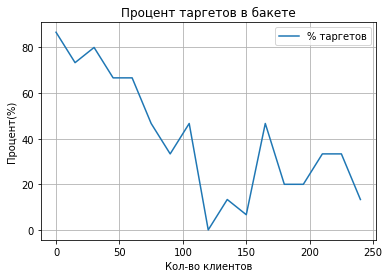

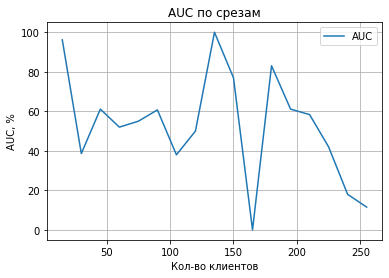

start_bucket  end_bucket  target_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          15                13       86.666667     12.621359   
1             15          30                11       73.333333     10.679612   
2             30          45                12       80.000000     11.650485   
3             45          60                10       66.666667      9.708738   
4             60          75                10       66.666667      9.708738   
5             75          90                 7       46.666667      6.796117   
6             90         105                 5       33.333333      4.854369   
7            105         120                 7       46.666667      6.796117   
8            120         135                 0        0.000000      0.000000   
9            135         150                 2       13.333333      1.941748   
10           150         165                 1        6.666667      0.970874   
11           165         180                 7       46.666667      6.796117   
12           180         195                 3       20.000000      2.912621   
13           195         210                 3       20.000000      2.912621   
14           210         225                 5       33.333333      4.854369   
15           225         240                 5       33.333333      4.854369   
16           240         255                 2       13.333333      1.941748   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.432836             2.255016   96.153846  
1      38.432836             1.908091   38.636364  
2      38.432836             2.081553   61.111111  
3      38.432836             1.734628   52.000000  
4      38.432836             1.734628   55.000000  
5      38.432836             1.214239   60.714286  
6      38.432836             0.867314   38.000000  
7      38.432836             1.214239   50.000000  
8      38.432836             0.000000  100.000000  
9      38.432836             0.346926   76.923077  
10     38.432836             0.173463    0.000000  
11     38.432836             1.214239   83.035714  
12     38.432836             0.520388   61.111111  
13     38.432836             0.520388   58.333333  
14     38.432836             0.867314   42.000000  
15     38.432836             0.867314   18.000000  
16     38.432836             0.346926   11.538462

In [60]:
# Метрика процента таргета для валидации

te_table_cover_2 = final_model.balance_cover_2(X_valid, y_valid, step=15, end=250)
te_table_cover_2

## Этап калибровки

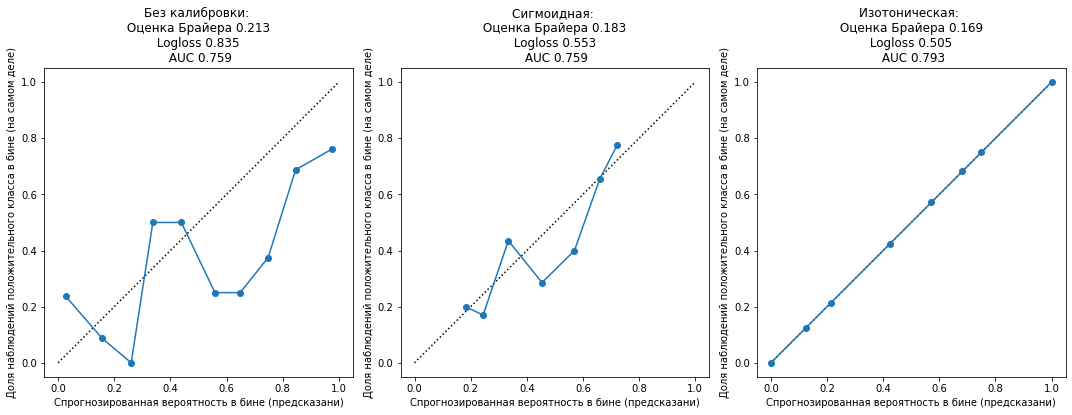

In [61]:
# Калибровка на валидации

final_model.calibration(X_valid, y_valid, n_bins=10)

### Формирование базового скора, сигмоидной калибровки и изотонической

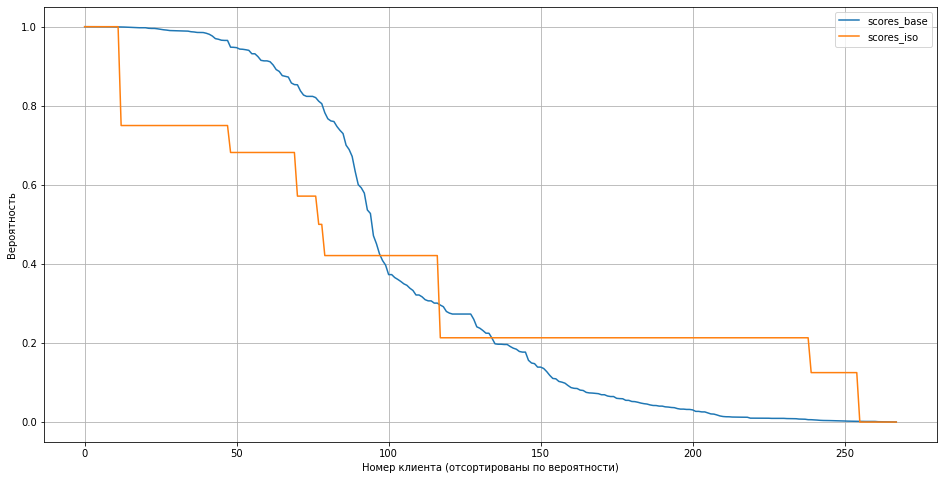

scores_base  scores_sigm  scores_iso  target
0       0.999999     0.730302         1.0       1
1       0.999992     0.730299         1.0       1
2       0.999985     0.730295         1.0       1
3       0.999973     0.730289         1.0       1
4       0.999968     0.730287         1.0       1
..           ...          ...         ...     ...
263     0.000681     0.175061         0.0       0
264     0.000590     0.175028         0.0       0
265     0.000515     0.175000         0.0       0
266     0.000240     0.174899         0.0       0
267     0.000134     0.174860         0.0       0

[268 rows x 4 columns]

In [62]:
# Выбор калибровки и сравнение с базовым скором

scores = final_model.calibration_compare(X_valid, y_valid, calib_compare='scores_iso')
scores

## Сохранение пиклов

In [63]:
final_model.get_pickles(
                columns=True,
                prep_pipe=True,
                model=True,
                calibration=True,
                type_calibration='iso',
                path='final_results')

'Все атрибуты сохранены!'

## Интерпретация модели

In [64]:
# Shap интерпретация

# задаем класс
c_shap = PlotShap(model=final_model.model, sample=final_model.prep_pipe.transform(X_train))
# обучаем
c_shap.fit_shap()

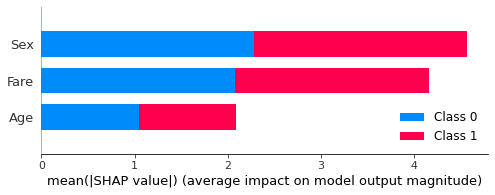

In [65]:
c_shap.create_plot_shap(plot_type='bar', number_features=30)

In [66]:
c_shap.create_shap_report(path_base='./shap_report')

In [67]:
# PDP-ICE интерпретация

# Задаем необходимые факторы для анализа, в нужном нам порядке
feats = features[:5]

# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=final_model.model, X=final_model.prep_pipe.transform(X_train),main_features=feats)

Sex


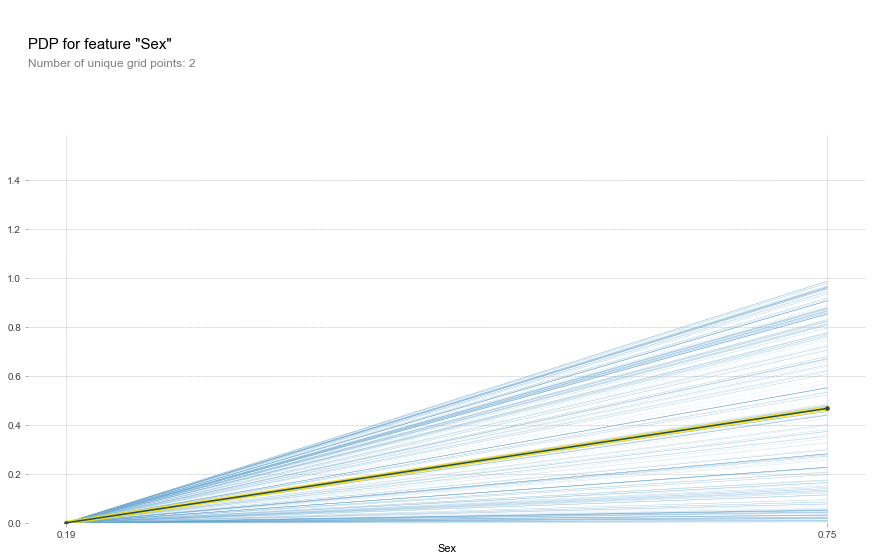

Fare


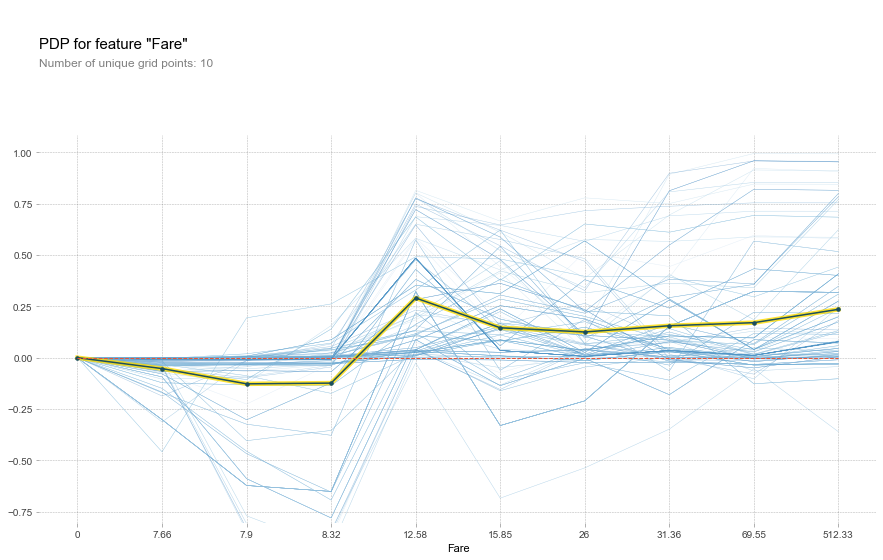

Age


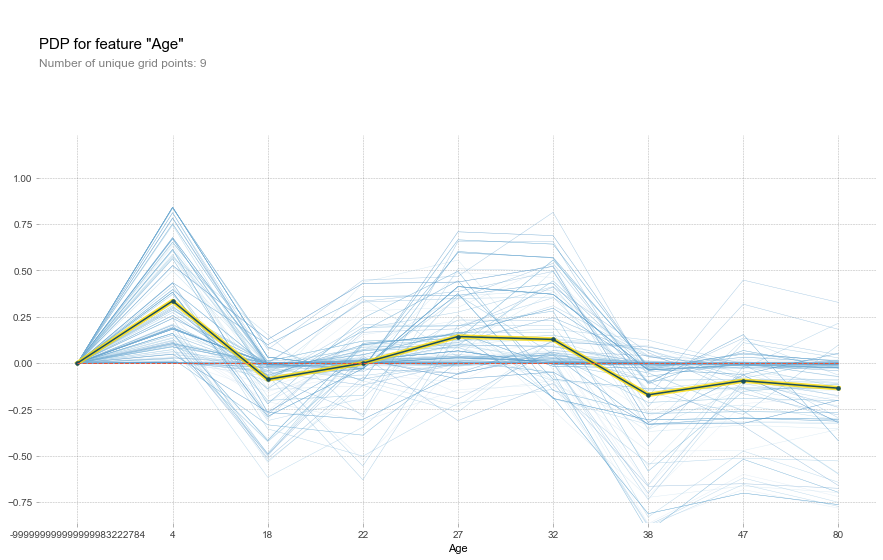

In [68]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=True, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Age'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


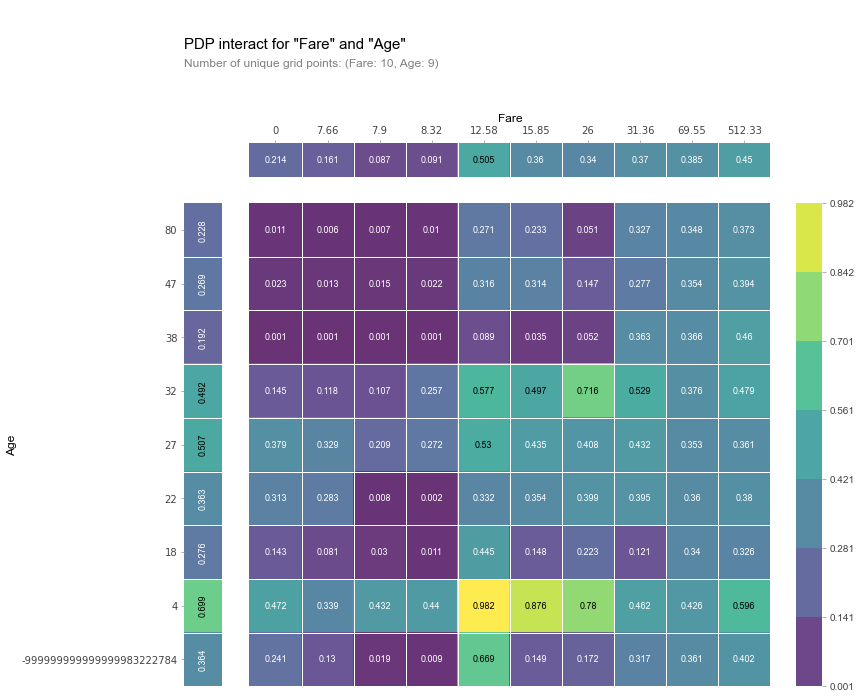

In [69]:
pdp_plot.create_interact_plot(features=['Fare','Age'], save=True)

In [70]:
# Генерация html отчета PDP-ICE plots функцией create_pdp_report(path_base = './pdp_ice_plots' - 'необходимая директория для графиков/отчета')

pdp_plot.create_pdp_report()

Загрузка всех сохраненных изображений 

Загрузка завершена. 

Отчет сгенерирован.
